In [1]:
!pip install transformers -q
!pip install sentencepiece -q

     |████████████████████████████████| 3.1 MB 8.2 MB/s 
     |████████████████████████████████| 59 kB 6.7 MB/s 
     |████████████████████████████████| 895 kB 43.6 MB/s 
     |████████████████████████████████| 3.3 MB 33.3 MB/s 
     |████████████████████████████████| 596 kB 41.5 MB/s 
     |████████████████████████████████| 1.2 MB 8.9 MB/s 


In [2]:
# Mount Google drive to upload datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# The path to the data on my drive
D = '/content/drive/My Drive/W266_Project_Data/pmi_data'

In [4]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Set up the device to run on GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
# Create an instance of the tokenizer and model using Indic Bert
tokenizer = AutoTokenizer.from_pretrained('ai4bharat/indic-bert', keep_accents=True)
model = AutoModel.from_pretrained('ai4bharat/indic-bert')

Downloading:   0%|          | 0.00/507 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.38M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/129M [00:00<?, ?B/s]

Some weights of the model checkpoint at ai4bharat/indic-bert were not used when initializing AlbertModel: ['predictions.dense.weight', 'sop_classifier.classifier.weight', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'sop_classifier.classifier.bias', 'predictions.bias', 'predictions.decoder.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
# Load the test paraphrase file
model_test = pd.read_csv(D+"/predicted_text/siamese_evaluations_of_translations/three_dense_w_punjabi_paraphrase_test_eval_and_errors_layernorm.csv")
model_test.drop(columns={'Unnamed: 0'}, inplace=True)

In [8]:
# View the first few records in each file
model_test.head()

,language,actual_label,predicted_label,sentence_1,sentence_2
0,translate English to Hindi,1,1,1984 में बारामती से उन्होंने पहली बार लोकसभा च...,बारामती से 1984 में उन्होंने पहली बार लोकसभा ...
1,translate English to Hindi,0,0,सुप्रीम कोर्ट की फटकार के बाद भी आजम अपने बयान...,सरकार का फर्ज बनता है कि लगातार हो रही एक जैस...
2,translate English to Hindi,1,1,"उत्तराखंड में जारी रहेगा राष्ट्रपति शासन, हाई...",उत्तराखण्ड में राष्ट्रपति शासन हटाने के नैनीता...
3,translate English to Hindi,1,0,भारत ने पृथ्वी-दो मिसाइल का किया सफल प्रक्षेपण,भारत ने आज परमाणु क्षमता संपन्न और स्वदेश में ...
4,translate English to Hindi,1,1,मीडिया रिपोर्ट्स में ये जानकारी नहीं है कि फा...,फाइनेंशियल मदद के तौर पर कितना अमाउंट दिया गय...


In [9]:
# Define the same sentence embeddings function used to create the model inputs
# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

def sentence_embeddings(device, tokenizer, model, sentences):
  """Create contextualized sentence embeddings
  
  Parameters:
  tokenizer: transformers tokenizer for creating word tokens
  model:
  sentences: sentences to generate sentence embeddings for
  """

  # Tokenize sentences and return PyTorch tensors
  encoded_input = tokenizer(sentences, padding=True, truncation=True, 
                            max_length=128, return_tensors='pt')
  encoded_input = encoded_input.to(device)
  
  # Pass the tokenized input to the model 
  with torch.no_grad():
    model.to(device)
    model_output = model(**encoded_input) 
  
  # Perform mean pooling to get total sentence embeddings
  sentence_embeddings = mean_pooling(model_output, 
                                     encoded_input['attention_mask'])
  
  return sentence_embeddings

In [10]:
# Get the sentence embeddings and cosine similarity scores between each pair of sentences in the dataset
# This is to check if low scoring sentences have exact similarity scores or if they are of low quality
def check_cosine_similarity(df, device, tokenizer, model):

  # Create an empty list to check cosine similarity scores
  cosine_scores = []

  for index, rows in df.iterrows():
    # Get the sentence embeddings of each pair of target sentences
    sent1_embed = sentence_embeddings(device, tokenizer, model, rows['sentence_1'])
    sent2_embed = sentence_embeddings(device, tokenizer, model, rows['sentence_2'])

    # Reshape the embeddings to be of a single dimension 
    # Get the cosine similarity between the two pairs of sentence embeddings
    cosine_similarity_value = F.cosine_similarity(sent1_embed.squeeze(0), sent2_embed.squeeze(0), dim=0)

    # Add the cosine similarity score to the list of scores
    cosine_scores.append(cosine_similarity_value.item())

  return cosine_scores

In [11]:
# Calculate the cosine similarity scores between each pair of sentences in the test set
test_cos_scores = check_cosine_similarity(model_test, device, tokenizer, model)

# Add the translation similarity scores to the indictrans performance dataframe
model_test['cosine_similarity_scores'] = test_cos_scores

In [12]:
# View the first few records in each file
model_test.head()

,language,actual_label,predicted_label,sentence_1,sentence_2,cosine_similarity_scores
0,translate English to Hindi,1,1,1984 में बारामती से उन्होंने पहली बार लोकसभा च...,बारामती से 1984 में उन्होंने पहली बार लोकसभा ...,0.994218
1,translate English to Hindi,0,0,सुप्रीम कोर्ट की फटकार के बाद भी आजम अपने बयान...,सरकार का फर्ज बनता है कि लगातार हो रही एक जैस...,0.716098
2,translate English to Hindi,1,1,"उत्तराखंड में जारी रहेगा राष्ट्रपति शासन, हाई...",उत्तराखण्ड में राष्ट्रपति शासन हटाने के नैनीता...,0.887607
3,translate English to Hindi,1,0,भारत ने पृथ्वी-दो मिसाइल का किया सफल प्रक्षेपण,भारत ने आज परमाणु क्षमता संपन्न और स्वदेश में ...,0.743594
4,translate English to Hindi,1,1,मीडिया रिपोर्ट्स में ये जानकारी नहीं है कि फा...,फाइनेंशियल मदद के तौर पर कितना अमाउंट दिया गय...,0.969318


In [13]:
# Create two sets - 1 for correct predictions, 1 for incorrect predictions
correct = model_test[model_test.actual_label == model_test.predicted_label]
incorrect = model_test[model_test.actual_label != model_test.predicted_label]

In [14]:
# Get the min and max of cosine similarity values for incorrect and correct examples
print(min(correct.cosine_similarity_scores))
print(max(correct.cosine_similarity_scores), "\n")

# The incorrect examples have a higher minimum cosine similarity score than that of the minimum of correctly labeled examples
print(min(incorrect.cosine_similarity_scores))
print(max(incorrect.cosine_similarity_scores))

0.505078911781311
0.9990821480751038 

0.616990327835083
0.9695484638214111


In [15]:
# Get the min and max values for paraphrases vs not paraphrases
p = model_test[model_test.actual_label == 1]
np = model_test[model_test.actual_label == 0]

In [16]:
# Get the min and max of cosine similarity values for paraphrases versus not paraphrases
print(min(p.cosine_similarity_scores))
print(max(p.cosine_similarity_scores), "\n")


print(min(np.cosine_similarity_scores))
print(max(np.cosine_similarity_scores))

0.616990327835083
0.9990821480751038 

0.505078911781311
0.9695484638214111


In [17]:
# View the row with the maximum cosine similarity score where the sentences are not paraphrases
print(np.loc[np.cosine_similarity_scores == max(np.cosine_similarity_scores), 'sentence_1'].iloc[0])
print(np.loc[np.cosine_similarity_scores == max(np.cosine_similarity_scores), 'sentence_2'].iloc[0])
print(np.loc[np.cosine_similarity_scores == max(np.cosine_similarity_scores), 'predicted_label'].iloc[0])
print(np.loc[np.cosine_similarity_scores == max(np.cosine_similarity_scores), 'language'].iloc[0])

மலேசிய நாட்டின் தலைநகரான கோலாலம்பூரில் வெள்ளையர் ஆட்சிக்கு எதிராக இந்திய தேசிய ராணுவத்தை உருவாக்கிய மாவீரர் நேதாஜி சுபாஷ் சந்திரபோசின் உருவச்சிலை திறந்து வைக்கப்பட்டது.
இந்திய பிரதமர் நரேந்திர மோடி கடந்த ஆண்டு மலேசியா வந்திருந்தபோது தலைநகர் கோலாலம்பூரில் உள்ள இந்திய கலாசார மையத்துக்கு நேதாஜி சுபாஷ் சந்திரபோசின் பெயர் சூட்டப்படும் என அறிவித்திருந்தார்.
1
translate English to Tamil


In [26]:
# Back translate to English
# The sentences have similar ideas in some places - prime minister, the entity Netaji Subhash Chandra
# However, the second sentence misses the importance of Netaji (no indication of why he is being honored)
sent_1 = 'A statue of Netaji Subhash Chandra Bose, the hero who created the Indian National Army against white rule, was unveiled in the Malaysian capital Kuala Lumpur.'
sent_2 = 'When Indian Prime Minister Narendra Modi visited Malaysia last year, he announced that the Indian Cultural Center in the capital Kuala Lumpur would be named after Netaji Subhash Chandra Bose.'

In [19]:
# Replace the long translation task text strings in-place with just the language names
model_test["language"] = model_test["language"].str.replace("translate English to Hindi", "Hindi", case = False)
model_test["language"] = model_test["language"].str.replace("translate English to Punjabi", "Punjabi", case = False)
model_test["language"] = model_test["language"].str.replace("translate English to Tamil", "Tamil", case = False)
model_test["language"] = model_test["language"].str.replace("translate English to Malayalam", "Malayalam", case = False)

In [20]:
model_test

,language,actual_label,predicted_label,sentence_1,sentence_2,cosine_similarity_scores
0,Hindi,1,1,1984 में बारामती से उन्होंने पहली बार लोकसभा च...,बारामती से 1984 में उन्होंने पहली बार लोकसभा ...,0.994218
1,Hindi,0,0,सुप्रीम कोर्ट की फटकार के बाद भी आजम अपने बयान...,सरकार का फर्ज बनता है कि लगातार हो रही एक जैस...,0.716098
2,Hindi,1,1,"उत्तराखंड में जारी रहेगा राष्ट्रपति शासन, हाई...",उत्तराखण्ड में राष्ट्रपति शासन हटाने के नैनीता...,0.887607
3,Hindi,1,0,भारत ने पृथ्वी-दो मिसाइल का किया सफल प्रक्षेपण,भारत ने आज परमाणु क्षमता संपन्न और स्वदेश में ...,0.743594
4,Hindi,1,1,मीडिया रिपोर्ट्स में ये जानकारी नहीं है कि फा...,फाइनेंशियल मदद के तौर पर कितना अमाउंट दिया गय...,0.969318
...,...,...,...,...,...,...
1595,Punjabi,1,1,ਉਂਜ ਹਰ ਡਿਪੂ ਨੂੰ ਘੱਟੋ-ਘੱਟ 25 ਨਵੀਆਂ ਬੱਸਾਂ ਦਿੱਤੀ...,ਉਂਜ ਘੱਟੋ-ਘੱਟ 25 ਨਵੀਆਂ ਬੱਸਾਂ ਹਰ ਡਿਪੂ ਨੂੰ ਦਿੱਤੀਆ...,0.991908
1596,Punjabi,1,1,ਇਨ੍ਹਾਂ ਵਿੱਚ 241 ਰਾਜਨੀਤੀ ਸ਼ਾਸਤਰ ਤੇ 170 ਇਤਿਹਾਸ ਦੇ...,170 ਇਤਿਹਾਸ ਦੇ ਅਤੇ 241 ਰਾਜਨੀਤੀ ਸ਼ਾਸਤਰ ਦੇ ਲੈਕਚਰਾ...,0.977593
1597,Punjabi,0,0,ਇਸਤੋਂ ਪਹਿਲਾਂ ਸ਼ੋਮਣੀ ਅਕਾਲੀ ਦਲ ਦੇ ਇਤਿਹਾਸ ਤੇ ਪਿਛਲੇ...,ਪਹਿਲਾਂ ਇਹ ਵੈੱਬਸਾਈਟ ਸਰਬੱਤ ਖ਼ਾਲਸਾ ਦੀ ਚੱਲ ਰਹੀ ਸੀ|,0.701737
1598,Punjabi,1,1,"ਟਾਸਕ ਫੋਰਸ ਖੇਡ ਸਹੂਲਤਾਂ, ਸਿਖਲਾਈ, ਚੋਣ ਅਮਲ ਤੇ ਇਨ੍ਹ...","ਖੇਡ ਸਹੂਲਤਾਂ, ਸਿਖਲਾਈ, ਚੋਣ ਅਮਲ ਤੇ ਇਨ੍ਹਾਂ ਨਾਲ ਸਬੰ...",0.985354


In [21]:
model_test.language.unique()

array(['Hindi', 'Malayalam', 'Tamil', 'Punjabi'], dtype=object)

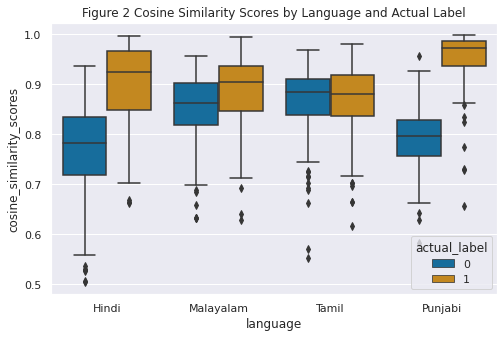

In [22]:
sns.set(rc={'figure.figsize':(11,6)})
sns.boxplot(x = model_test['language'],
            y = model_test['cosine_similarity_scores'],
            hue = model_test['actual_label'], palette="colorblind").set_title('Figure 2 Cosine Similarity Scores by Language and Actual Label')
plt.gcf().set_size_inches(8, 5)

Text(0.5, 1.0, 'Cosine Similarity Scores of P Predicted to be NP')

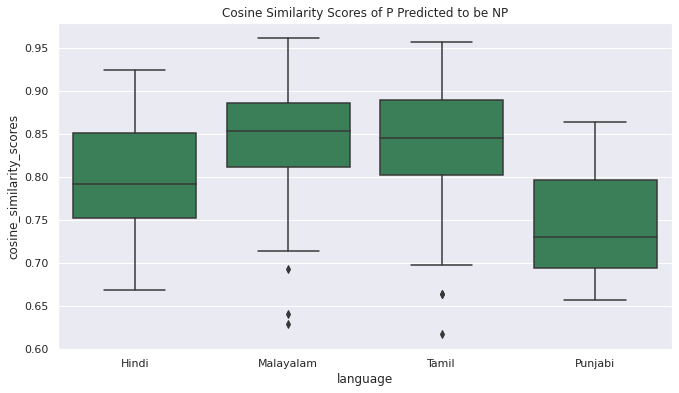

In [23]:
# Let's look at the separation in cosine scores for incorrectly labeled examples that are paraphrases, but the model predicts them not to be
pred_0_actual_1 = model_test[(model_test.predicted_label == 0) & (model_test.actual_label == 1)]
sns.boxplot(x = pred_0_actual_1['language'],
            y = pred_0_actual_1['cosine_similarity_scores'],color="seagreen").set_title('Cosine Similarity Scores of P Predicted to be NP')


Text(0.5, 1.0, 'Cosine Similarity Scores of NP Predicted to be P')

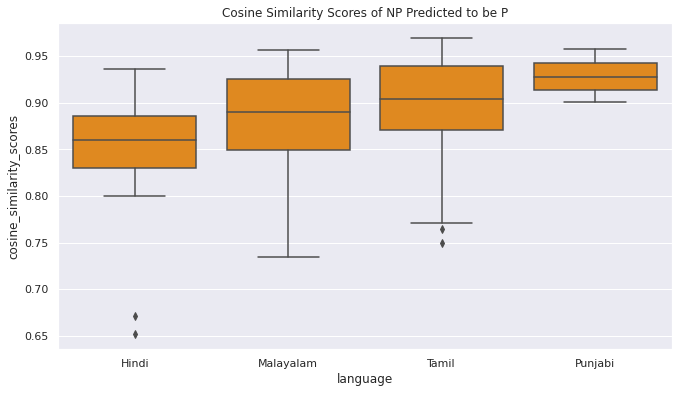

In [24]:
# Let's look at the separation in cosine scores for incorrectly labeled examples that are not paraphrases, but the model predicts them to be
pred_1_actual_0 = model_test[(model_test.predicted_label == 1) & (model_test.actual_label == 0)]
sns.boxplot(x = pred_1_actual_0['language'],
            y = pred_1_actual_0['cosine_similarity_scores'],color="darkorange").set_title('Cosine Similarity Scores of NP Predicted to be P')


In [25]:
# Look at an example sentence where the model is predicting not paraphrase for Tamil sentences that are paraphrases - the most frequent model mistake
pred_1_actual_0_ta = pred_1_actual_0[pred_1_actual_0.language == 'Tamil'].reset_index().sort_values("cosine_similarity_scores", ascending=False)
# All of these sentences have high cosine similarity scores
pred_1_actual_0_ta.head()

,index,language,actual_label,predicted_label,sentence_1,sentence_2,cosine_similarity_scores
41,1296,Tamil,0,1,மலேசிய நாட்டின் தலைநகரான கோலாலம்பூரில் வெள்ளைய...,இந்திய பிரதமர் நரேந்திர மோடி கடந்த ஆண்டு மலேசி...,0.969548
29,1149,Tamil,0,1,சர்வதேச தரவரிசையில் இந்திய டென்னிஸ் வீரர் யூகி...,சென்னையில் நடந்த போட்டியில் இந்திய டென்னிஸ் வீ...,0.967987
19,1088,Tamil,0,1,குழந்தைகள் காணாமல்போய் 7 ஆண்டுகளுக்கு மேல் கண்...,"ஓர் ஆண்டு முதல் 7 ஆண்டுகள் வரை கடத்தப்பட்ட, கண...",0.967232
11,1004,Tamil,0,1,ஹராரேயில் நடைபெற்ற 2-வது டி20 போட்டியில் இந்தி...,இந்தியா- ஜிம்பாப்வே அணிகளுக்கு இடையிலான 2-வது ...,0.963441
16,1063,Tamil,0,1,"சர்வதேச யோகா தினமான ஜூன் 21-ம்தேதி, இந்தியா ம...","பிரதமர் நரேந்திரமோடியின் வேண்டுகோளை ஏற்று, ஜ...",0.949880
